In [48]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import nibabel as nib
import scipy
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import copy
import glob
sys.path.insert(1, '/export03/data/opt/Hippo_Spin_Testing')
from hippo_spin_testing import spin_test
sys.path.insert(1, '/data/mica1/01_programs/micapipe-v0.2.0/functions')
from build_mpc import build_mpc
from brainspace.gradient import GradientMaps
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [49]:
files = []
for hemi in ['mix','L']: files.extend(glob.glob(f'../maps/*_average-*_hemi-{hemi}_den-*_label-hipp.shape.gii'))
files = list(set(files) - set(glob.glob(f'../maps/*FCG1to5_average-*_hemi-*_den-*_label-hipp.shape.gii')))
files.sort()
files

features = []
cdata = np.ones((7262,len(files)))
for f in range(len(files)):
    features.append(files[f][8:].split('_')[0])
    den = files[f][8:].split('_')[3][4:]
    cdata[:,f],_,_ = utils.density_interp(den,'0p5mm',nib.load(files[f]).darrays[0].data, label='hipp')


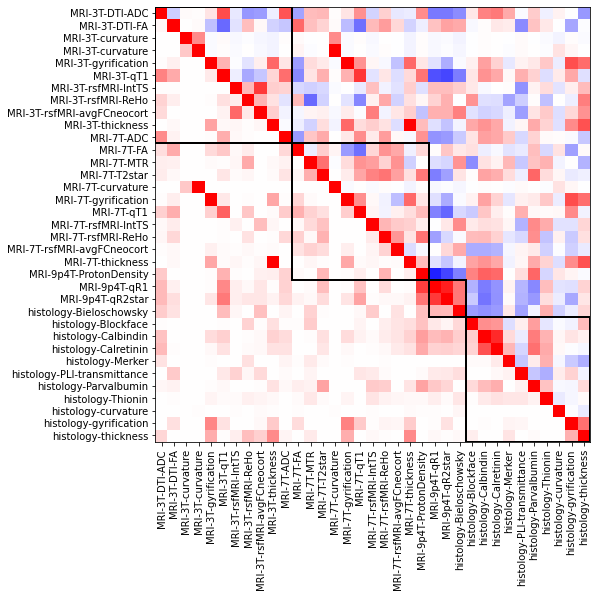

In [50]:
feat_corr = np.corrcoef(cdata.T)
iloc = np.tril_indices(len(feat_corr))
feat_corr[iloc] = feat_corr[iloc]**2

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(feat_corr, vmin=-1, vmax=1, cmap='bwr')
plt.yticks(ticks=range(len(features)),labels=features);
plt.xticks(ticks=range(len(features)),labels=features, rotation=90);

blocks = [0,11,22,25,len(features)]
for i in range(len(blocks)-1):
    w = blocks[i+1]-blocks[i]
    rect = Rectangle((blocks[i]-.5,blocks[i]-.5),w,w, linewidth=2, edgecolor='k', facecolor='none')
    ax.add_patch(rect)

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


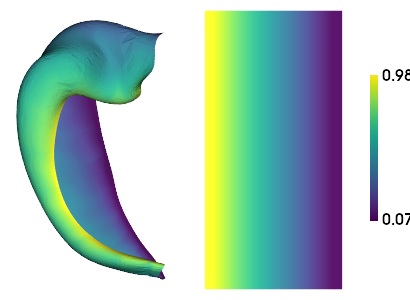

In [42]:
subfields = nib.load('/data/mica3/BIDS_PNI/derivatives/hippunfold_v1.3.0_supersession/hippunfold/sub-PNC002/surf/sub-PNC002_hemi-L_space-T1w_den-0p5mm_label-hipp_atlas-histologyReference2023_subfields.label.gii').darrays[0].data
AP,_,_ = utils.density_interp('unfoldiso','0p5mm',repmat(np.linspace(0,1,254),126,1).flatten(), label='hipp')
PD,_,_ = utils.density_interp('unfoldiso','0p5mm',repmat(np.linspace(0,1,126),254,1).T.flatten(), label='hipp')
plotting.surfplot_canonical_foldunfold(PD, color_bar=('right'), hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', tighten_cwindow=True, embed_nb=True)

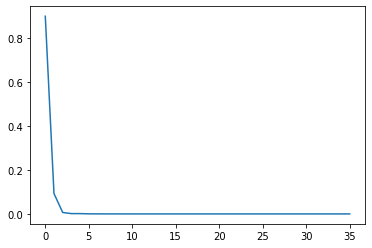

In [47]:
pca = PCA()
principalComponents = pca.fit_transform(cdata)
plt.plot(pca.explained_variance_ratio_)

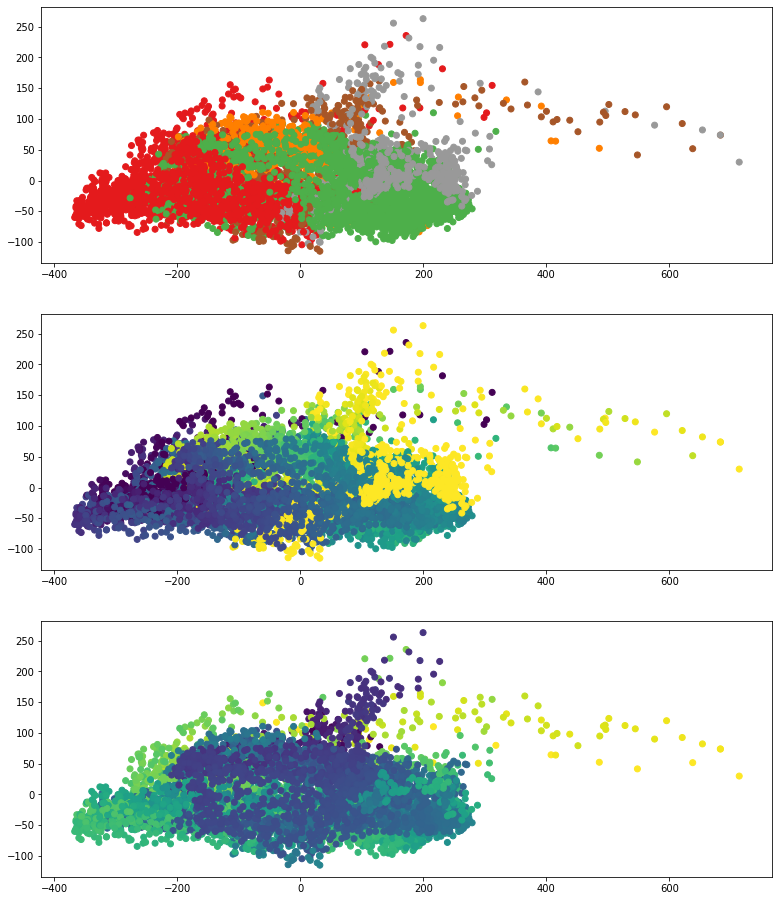

In [44]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(32, 16))
ax[0].scatter(principalComponents[:,0], principalComponents[:,1], c=subfields, cmap='Set1')
ax[0].set_aspect('equal', 'box')
ax[1].scatter(principalComponents[:,0], principalComponents[:,1], c=PD)
ax[1].set_aspect('equal', 'box')
ax[2].scatter(principalComponents[:,0], principalComponents[:,1], c=AP)
ax[2].set_aspect('equal', 'box')

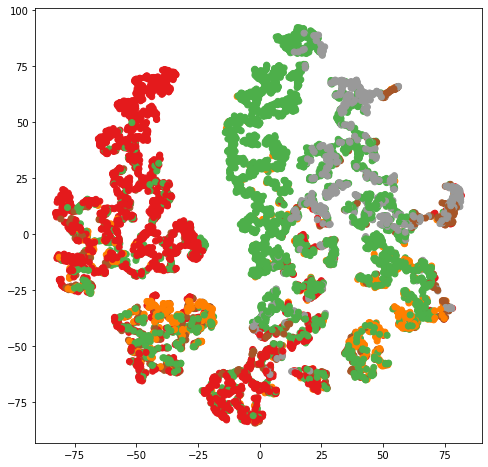

In [45]:
X_embedded = TSNE().fit_transform(principalComponents[:,:2])
subfields = nib.load('/data/mica3/BIDS_PNI/derivatives/hippunfold_v1.3.0_supersession/hippunfold/sub-PNC002/surf/sub-PNC002_hemi-L_space-T1w_den-0p5mm_label-hipp_atlas-histologyReference2023_subfields.label.gii').darrays[0].data

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_embedded[:,0], X_embedded[:,1], c=subfields, cmap='Set1')

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


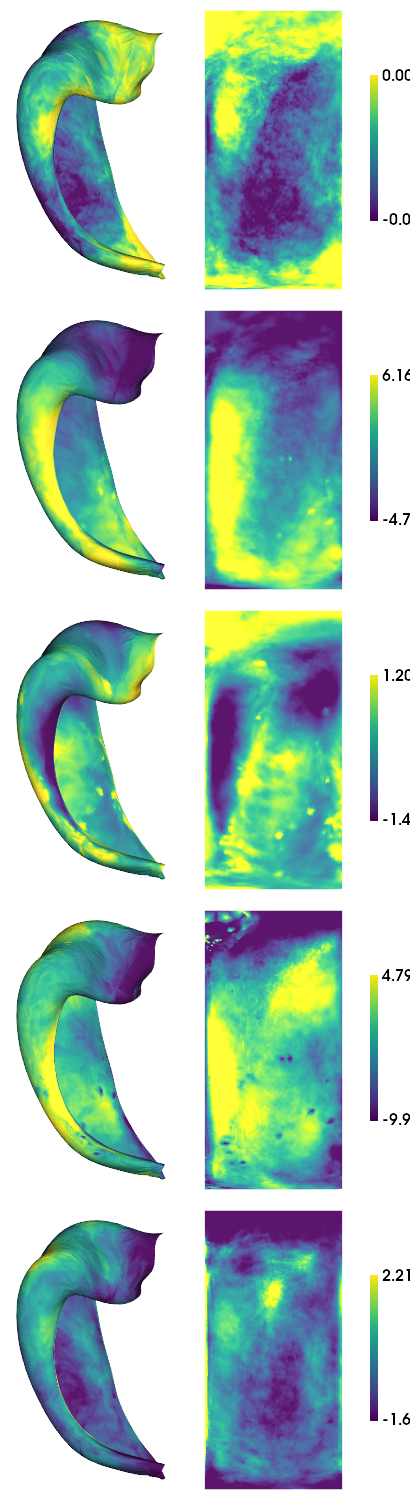

In [46]:
# gradient decomposition
ngrads=5
mmgm = GradientMaps(n_components=ngrads, kernel='cosine', random_state=0)
mmgm.fit(cdata, sparsity=0.1)
plotting.surfplot_canonical_foldunfold(mmgm.gradients_, labels=['hipp'], hemis=['L'], unfoldAPrescale=True, color_bar='right', share='row', tighten_cwindow=True, embed_nb=True)

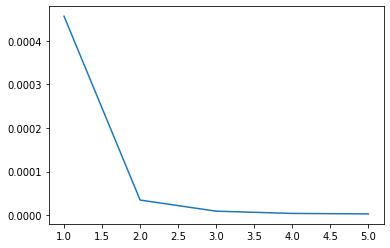

In [27]:
plt.plot(np.arange(ngrads)+1,mmgm.lambdas_)

In [28]:
mmgm.gradients_.shape

(7262, 5)

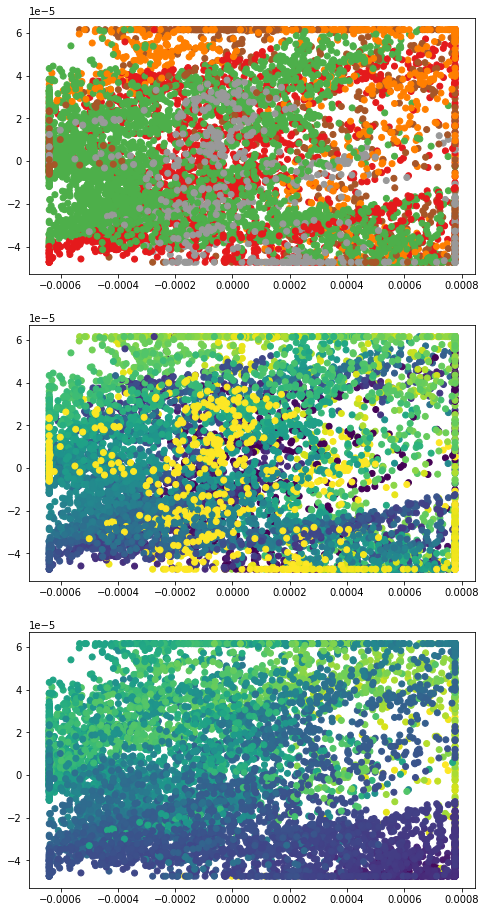

In [29]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 16))
ax[0].scatter(mmgm.gradients_[:,0], mmgm.gradients_[:,1], c=subfields, cmap='Set1')
ax[1].scatter(mmgm.gradients_[:,0], mmgm.gradients_[:,1], c=PD)
ax[2].scatter(mmgm.gradients_[:,0], mmgm.gradients_[:,1], c=AP)

## include liminae

In [2]:
downsampled_histo = np.load("../checkpoints/struct-HISTO-proc-averaged.npy")
cdata = np.load("../checkpoints/struct-PNI-averaged.npy")
struct_data = np.concatenate((downsampled_histo,cdata),axis=2)

allfeatures = ['Merker', 'PLI-transmittance', 'Blockface', 'Bieloschowsky', 'Calbindin', 'Calretinin', 'Parvalbumin', 'Thionin', 'ProtonDensity', 'qR1', 'qR2star', \
               'T1map', 'MTR', 'T2star', 'FA', 'ADC']

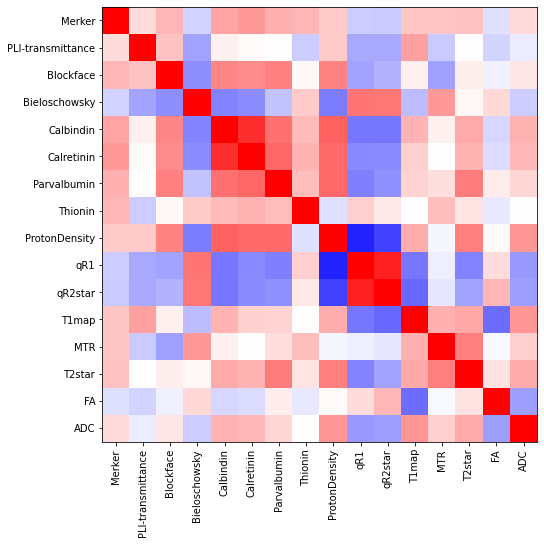

In [3]:
# correlation between features
feat_corr = np.corrcoef(struct_data.reshape(7262*17,16).T)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(feat_corr, vmin=-1, vmax=1, cmap='bwr')
plt.yticks(ticks=range(len(allfeatures)),labels=allfeatures);
plt.xticks(ticks=range(len(allfeatures)),labels=allfeatures, rotation=90);

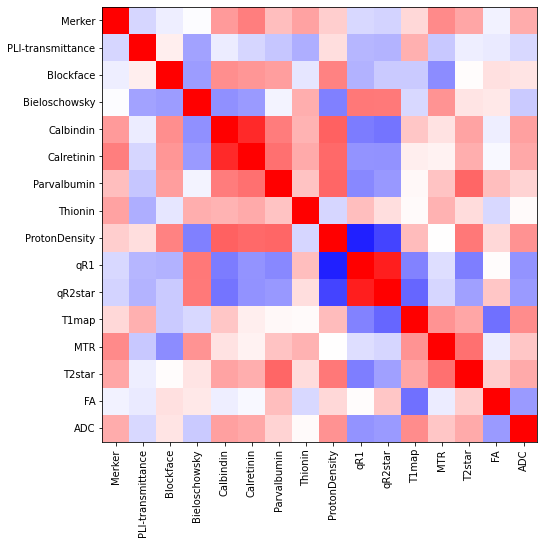

In [12]:
# correlation between features
feat_corr = np.corrcoef(np.nanmean(struct_data,axis=1).T)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(feat_corr, vmin=-1, vmax=1, cmap='bwr')
plt.yticks(ticks=range(len(allfeatures)),labels=allfeatures);
plt.xticks(ticks=range(len(allfeatures)),labels=allfeatures, rotation=90);

In [13]:
feat_corr_correct_R = np.zeros((len(allfeatures),len(allfeatures)))
feat_corr_correct_p = np.zeros((len(allfeatures),len(allfeatures)))
for i in range(len(allfeatures)):
    for j in range(i+1,len(allfeatures)):
        _,_,feat_corr_correct_p[i,j],feat_corr_correct_R[i,j] = spin_test.spin_test(np.nanmean(struct_data[:,:,i],axis=1),np.nanmean(struct_data[:,:,j],axis=1), 1000, space='orig')

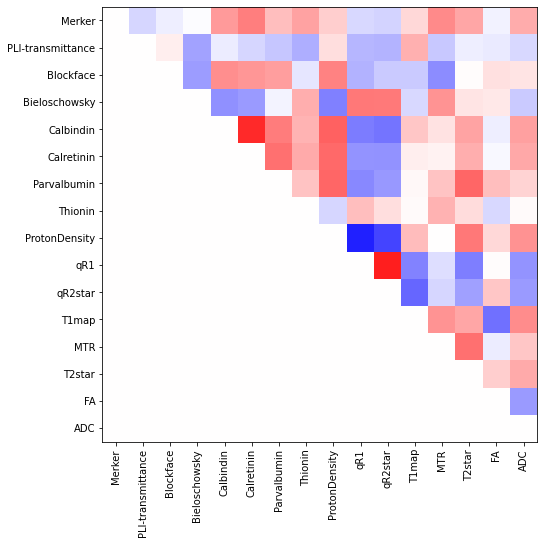

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(feat_corr_correct_R, vmin=-1, vmax=1, cmap='bwr')
plt.yticks(ticks=range(len(allfeatures)),labels=allfeatures);
plt.xticks(ticks=range(len(allfeatures)),labels=allfeatures, rotation=90);

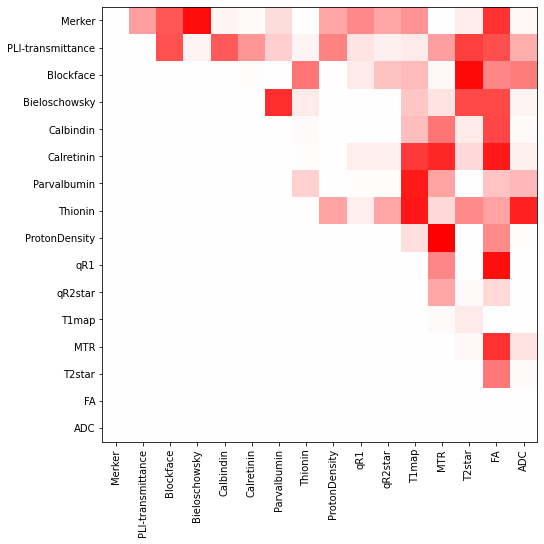

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(feat_corr_correct_p, vmin=-1, vmax=1, cmap='bwr')
plt.yticks(ticks=range(len(allfeatures)),labels=allfeatures);
plt.xticks(ticks=range(len(allfeatures)),labels=allfeatures, rotation=90);

In [ ]:
# gradient decomposition
ngrads=5
mmgm = GradientMaps(n_components=ngrads, kernel='cosine', random_state=0)
mmgm.fit(struct_data.reshape(7262,17*16), sparsity=0.1)
plotting.surfplot_canonical_foldunfold(mmgm.gradients_, labels=['hipp'], hemis=['L'], unfoldAPrescale=True, color_bar='right', share='row', tighten_cwindow=True, embed_nb=True)

In [ ]:
plt.plot(np.arange(ngrads)+1,mmgm.lambdas_)